In [13]:
import numpy as np

# Constants
N = 100
x_edges = np.linspace(-1.0, 1.0, N+1)
x = 0.5 * (x_edges[:-1] + x_edges[1:])
dx = x[1] - x[0]
lat_deg = np.degrees(np.arcsin(x))

# Physical constants
S0 = 1366.0
Q = S0 / 4.0
S_x = Q * (1 - 0.482 * x**2) * 1.35 - 55

sigma = 5.67e-8
epsilon = 0.63
D = 0.6
dt = dx**2 / (2 * D) * 0.5
tol = 1e-9
max_iter = 100000

# Initial guess
T = 288.0 + 60.0 * (1 - x**2) - 20.0  # in Kelvin

# Albedo: linear function of T
def albedo_linear(T):
    T1 = 223.15
    T2 = 293.15
    a1 = 0.9
    a2 = 0.2
    alpha = np.where(T <= T1, a1, np.where(T >= T2, a2, a1 + (a2 - a1) * (T - T1) / (T2 - T1)))
    return alpha

# Diffusion operator: d/dx[(1 - x^2) dT/dx]
def calc_dT2dx2(T):
    dT2dx2 = np.zeros_like(T)
    for i in range(N):
        dTdx_m = 0.0 if i == 0 else (T[i] - T[i-1]) / dx
        dTdx_p = 0.0 if i == N-1 else (T[i+1] - T[i]) / dx
        x_m = x_edges[i]
        x_p = x_edges[i+1]
        dT2dx2[i] = (1.0 / dx) * ((1 - x_p**2) * dTdx_p - (1 - x_m**2) * dTdx_m)
    return dT2dx2

# Iterative solver
for n in range(max_iter):
    alpha = albedo_linear(T)
    F_in = S_x * (1 - alpha)
    F_out = epsilon * sigma * T**4
    F_diff = D * calc_dT2dx2(T)
    dTdt = F_in - F_out + F_diff
    T_new = T + dt * dTdt
    if np.sum(np.abs(T_new - T)) < tol:
        print(f"Converged in {n+1} iterations.")
        break
    T = T_new


Converged in 82428 iterations.


In [17]:
T_final = T - 273.15

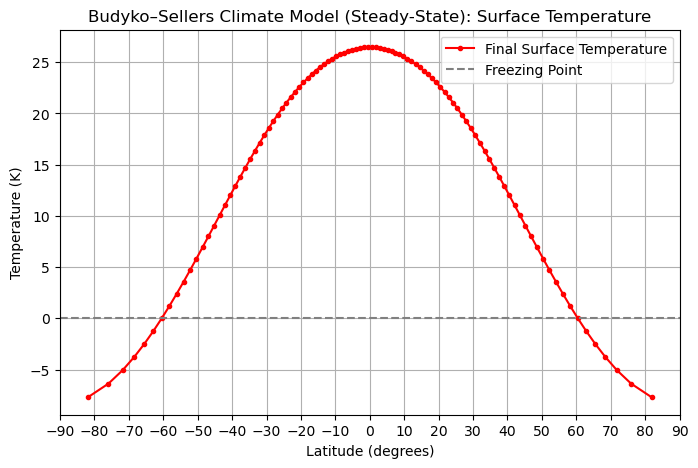

In [18]:
plt.figure(figsize=(8, 5))
#plt.plot(lat_deg, T_s[:,0], '.b-', label='Initial Surface Temperature')
plt.plot(lat_deg, T_final, '.r-', label='Final Surface Temperature')
plt.axhline(0, color='gray', linestyle='--', label='Freezing Point')
plt.title('Budyko–Sellers Climate Model (Steady-State): Surface Temperature')
plt.xlabel('Latitude (degrees)')
plt.ylabel('Temperature (K)')
plt.grid(True)
plt.legend()
plt.xticks(np.linspace(-90, 90, 19));
plt.show()

In [ ]:

# Save output to text files
import pandas as pd
#import ace_tools as tools

results = pd.DataFrame({
    "latitude_deg": lat_deg,
    "temperature_K": T,
    "albedo": albedo_linear(T),
    "F_in": F_in,
    "F_out": F_out,
    "F_diff": F_diff,
    "net_flux": F_in - F_out + F_diff
})
tools.display_dataframe_to_user(name="Budyko-Sellers Output", dataframe=results)

# Save as individual text files
results["latitude_deg"].to_csv("latitude.txt", index=False, header=False)
results["temperature_K"].to_csv("temperature.txt", index=False, header=False)
results["albedo"].to_csv("albedo.txt", index=False, header=False)
results["F_in"].to_csv("F_in.txt", index=False, header=False)
results["F_out"].to_csv("F_out.txt", index=False, header=False)
results["F_diff"].to_csv("F_diff.txt", index=False, header=False)
results["net_flux"].to_csv("net_flux.txt", index=False, header=False)
